In [3]:
# Importing stuff
import pandas as pd
import numpy as np

import glob

In [4]:
# Here, we made a group of dfs, each df representing the game-logs of one season.

path = f'C:\Users\suhan\Programming\JokicPrediction\Data'
raw_datafiles = glob.glob(f"{path}/*.csv")
dfs = {file.split('/')[-1].split('.')[0]: pd.read_csv(file) for file in raw_datafiles}

for year in range(2020,2025):
    dfs[f'Data\\{year}'].set_index('G',inplace=True)

The data needs to be tidied up. Here's what we need to do :
Use only the following stats as features : {MP,FG,FGA,3P,3PA,FT,FTA,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-}, since the other statistics are either redundant or useless.

In [5]:
features = {'MP','FG','FGA','3P','3PA','FT','FTA', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc','+/-'}
num_features = len(features)

# Removing seconds for convenience.

def second_remove(s):
    s = str(s)
    return int(s[:2])

for i in range(2020, 2025):

    dfs[f'Data\\{i}'] = dfs[f'Data\\{i}'][list(features)]
    dfs[f'Data\\{i}']['MP'] = dfs[f'Data\\{i}']['MP'].apply(second_remove)
    dfs[f'Data\\{i}'] = dfs[f'Data\\{i}'].apply(pd.to_numeric, errors = 'coerce')

dfs['Data\\2020'].describe()

,DRB,+/-,ORB,FGA,FTA,PTS,MP,FG,STL,3P,FT,PF,TOV,3PA,BLK,GmSc,AST
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,7.465753,3.493151,2.273973,14.671233,4.123288,19.945205,31.438356,7.739726,1.164384,1.095890,3.369863,3.041096,3.095890,3.493151,0.602740,18.484932,7.013699
std,3.253554,9.744120,1.565782,5.088262,3.201324,8.202118,5.204128,3.131504,1.080300,1.180447,2.637901,1.252091,1.959056,2.141672,0.812057,8.302421,3.039066
min,1.000000,-16.000000,0.000000,1.000000,0.000000,2.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.400000,0.000000
25%,5.000000,-3.000000,1.000000,11.000000,2.000000,14.000000,29.000000,5.000000,0.000000,0.000000,1.000000,2.000000,2.000000,2.000000,0.000000,13.400000,5.000000
50%,7.000000,3.000000,2.000000,15.000000,4.000000,20.000000,32.000000,7.000000,1.000000,1.000000,3.000000,3.000000,3.000000,3.000000,0.000000,17.100000,7.000000
75%,9.000000,10.000000,3.000000,19.000000,6.000000,25.000000,34.000000,10.000000,2.000000,2.000000,5.000000,4.000000,4.000000,5.000000,1.000000,23.000000,10.000000
max,18.000000,25.000000,7.000000,25.000000,16.000000,47.000000,43.000000,16.000000,4.000000,4.000000,11.000000,6.000000,9.000000,9.000000,3.000000,42.900000,13.000000


In [6]:
# Importing TF and the TCN.

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsolutePercentageError
from tcn import TCN
from sklearn.preprocessing import StandardScaler

Temporal Convolutional Network

In [7]:
# The model consists of a temporal convolutional network, a ReLU, and a linear layer.

model = Sequential([
    
    # Temporal Convolutional Network layer
    TCN(input_shape = (num_features, 1), 
        kernel_size = 2, 
        use_skip_connections=True,
        use_batch_norm=True,
        use_layer_norm=True),
    
    # Dropout for regularization
    Dropout(0.2),

    # Fully connected layers
    Dense (4, 'relu'),
    Dense(1, activation='linear')
])


optimizer = Adam(learning_rate=0.01)
loss = MeanAbsolutePercentageError()

model.compile(optimizer = optimizer,loss = loss)
model.summary()

C:\Users\suhan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tcn\tcn.py:227: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn (TCN)                       │ (None, 64)             │        94,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,473 (369.04 KB)

 Trainable params: 92,937 (363.04 KB)

 Non-trainable params: 1,536 (6.00 KB)

In [8]:
scaler = StandardScaler() # Converting into Z-score

for year in range(2021, 2024):

    # Shifting by 1, as we are using the data of the previous game to predict the 'PTS' of the next.
    dfs[f'Data\\{year}']['PtsNextGame'] = (dfs[f'Data\\{year}'])['PTS'].shift(-1) 

    X = dfs[f'Data\\{year}'].drop('PtsNextGame', axis = 1)
    y = dfs[f'Data\\{year}']['PtsNextGame']

    # Removing the NaN values formed at the last due to the shift

    X = X.iloc[:-1]
    y = y.iloc[:-1]

    X = X.to_numpy()
    y = y.to_numpy()

    X = X.reshape((X.shape[0], X.shape[1]))
    y = y.reshape(y.shape[0],1)

    X_normalized = scaler.fit_transform(X)

    model.fit(X_normalized,y,epochs = 10)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - loss: 64.9615
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 43.8067
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 36.7112
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 31.8193
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 24.2730
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 25.9150
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 28.6099
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 23.3905
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 22.2048
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 23.9136
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 24.7314
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 27.6292
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 25.6154
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 23.1151
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 23.4454
Epoch 6/10
3/3 ━━━━━━━━

Here, we are using the 2021 to 2023 seasons for training, and the 2024 season for testing. We essentially treat each season as a batch, feeding them to the model one at a time. Did not include the 2020 season as it is the only non MVP-level season of the sample set, and was messing with the predictions.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

dfs[f'Data\\2024']['PtsNextGame'] = (dfs[f'Data\\2024'])['PTS'].shift(-1) # Shifting by 1.

X_test = dfs['Data\\2024'].drop('PtsNextGame', axis = 1)
X_test = X_test.iloc[:-1] # Removing NaN value formed by shift.
X_test = scaler.fit_transform(X_test)

y_test = dfs['Data\\2024']['PtsNextGame']
y_test = y_test.iloc[:-1] # Removing NaN value formed by shift.

predictions = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step


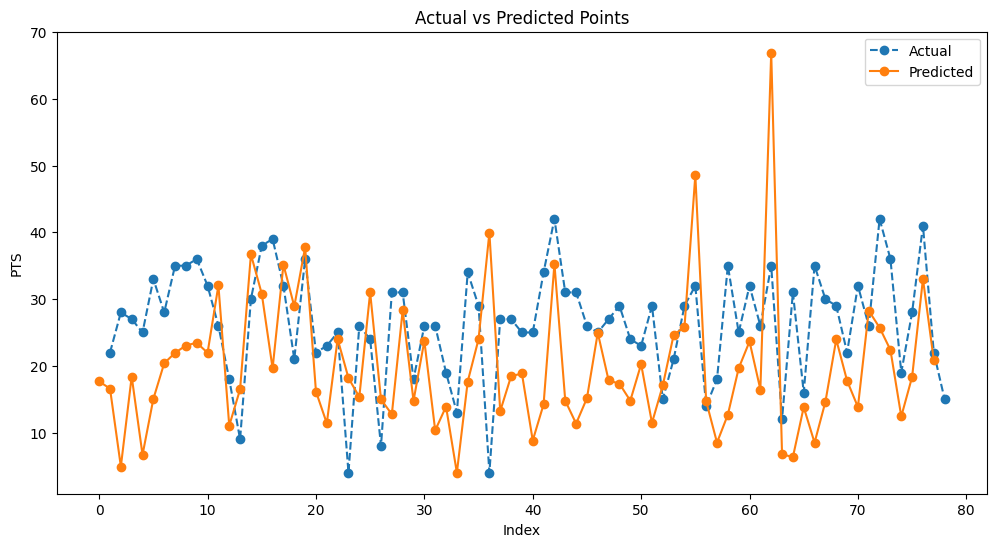

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', linestyle='--', marker='o')
plt.plot(predictions, label='Predicted', linestyle='-', marker='o')
plt.xlabel('Index')
plt.ylabel('PTS')
plt.title('Actual vs Predicted Points')
plt.legend()
plt.show()

As we can see, the model matches the peaks pretty well, consdering the non-linearity and uneven distribution of this dataset. With some human intuition, it could be pretty useful.

In [11]:
# Euclidean Distance

model.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 64.6886 


63.76378631591797

<Axes: >

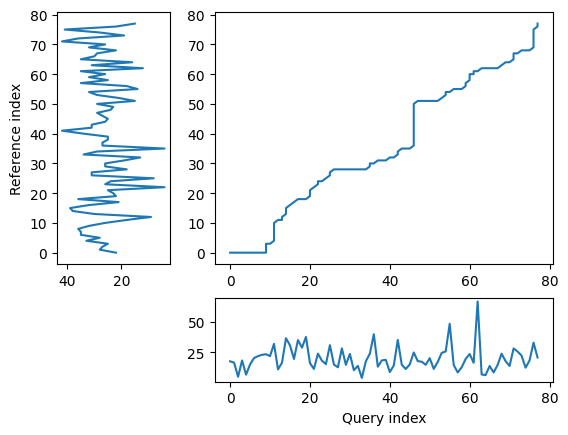

In [13]:
# Dynamic Time Warping algorithm similarity test 

from dtw import *

query = predictions
template = y_test.to_numpy()

alignment = dtw(query, template, keep_internals=True)
alignment.plot(type="threeway")

As we can see, the warping required appears relatively minimal, with the curve stationed along the diagonal.